In [1]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pylab
from scipy import stats

sns.set()

In [2]:
# Load dataset
orders = pd.read_csv('orders.csv').drop(['Unnamed: 0'],axis=1)
orders.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,CancelledOrder,InternationalOrders,TotalPrice
0,536365,85123A,6,2010-12-01 08:26:00,2.55,C17850,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,0,0,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,C17850,United Kingdom,WHITE METAL LANTERN,0,0,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,C17850,United Kingdom,CREAM CUPID HEARTS COAT HANGER,0,0,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,C17850,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,0,0,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,C17850,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,0,0,20.34


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404618 entries, 0 to 404617
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   InvoiceNo            404618 non-null  object 
 1   StockCode            404618 non-null  object 
 2   Quantity             404618 non-null  int64  
 3   InvoiceDate          404618 non-null  object 
 4   UnitPrice            404618 non-null  float64
 5   CustomerID           404618 non-null  object 
 6   Country              404618 non-null  object 
 7   Description          404618 non-null  object 
 8   CancelledOrder       404618 non-null  int64  
 9   InternationalOrders  404618 non-null  int64  
 10  TotalPrice           404618 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 34.0+ MB


In [4]:
# Convert InvoiceDate to datetime object
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)

# Truncate the minutes part of datetime object
orders['InvoiceDate'] = orders.InvoiceDate.dt.date

In [5]:
# Confirm all cancelled orders have negative TotalPrice and Quantity

print(orders[(orders.InvoiceNo.str.startswith('C')) & (orders.TotalPrice>0)])
print(orders[(orders.InvoiceNo.str.startswith('C')) & (orders.Quantity>0)])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []
Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []


We will drop following columns:
1. InvoiceNo and CustomerID: As we have to predict itemwise sales, we don't need these columns 
1. Country, InternationalOrders: We are not making distinction between international or domestic sales in the predictions, so we don't need this column
1. Description: We have the StockCode, so this is repetitive
1. CancelledOrder: Cancelled orders have negative quantity and price. So while aggregating the dataset, cancellations will be taken into account. We don't need this column.
1. UnitPrice: In our dataset, same item has different prices. So we will keep TotalPrice and drop UnitPrice. While aggregating we will calculate the UnitPrice from TotalPrice and Quantity for each item and month again.

In [6]:
orders.drop(['InvoiceNo', 'CustomerID','Country','InternationalOrders','Description','CancelledOrder','UnitPrice'],
            axis=1,inplace=True)

### Feature Engineering

In [7]:
orders.head()

,StockCode,Quantity,InvoiceDate,TotalPrice
0,85123A,6,2010-12-01,15.30
1,71053,6,2010-12-01,20.34
2,84406B,8,2010-12-01,22.00
3,84029G,6,2010-12-01,20.34
4,84029E,6,2010-12-01,20.34


In [8]:
# holidays = ['2010-12-27', '2010-12-28', '2011-01-03', '2011-04-22', '2011-04-25', '2011-04-29', '2011-05-02',
#             '2011-05-30', '2011-08-29']
# temp = pd.DataFrame({'InvoiceDate':holidays})
# temp['StockCode'] = 0
# temp['Quantity'] = 0
# temp['TotalPrice'] = 0
# orders.append(temp,ignore_index=True,sort=False)

In [9]:
orders = orders.groupby(['InvoiceDate','StockCode'],as_index=False).sum()
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)

In [11]:
# Use isocalendar to get the week number
orders['Week'] = orders.InvoiceDate.dt.isocalendar().week
orders['Quarter'] = orders.InvoiceDate.dt.quarter
orders['Month'] = orders.InvoiceDate.dt.month
orders['Weekday'] = orders.InvoiceDate.dt.weekday
orders['Day'] = orders.InvoiceDate.dt.day


In [12]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Year,Quarter,Month,Week,Weekday,Day
0,2010-12-01,10002,60,51.00,2010,4,12,48,2,1
1,2010-12-01,10125,2,1.70,2010,4,12,48,2,1
2,2010-12-01,10133,5,4.25,2010,4,12,48,2,1
3,2010-12-01,15044B,1,2.95,2010,4,12,48,2,1
4,2010-12-01,15056BL,20,113.00,2010,4,12,48,2,1


In [13]:
orders.describe()

,InvoiceDate,Quantity,TotalPrice,Year,Quarter,Month,Week,Weekday,Day
count,224628,224628.000000,224628.000000,224628.000000,224628.000000,224628.000000,224628.0,224628.000000,224628.000000
mean,2011-06-30 11:26:56.047866112,21.755712,36.874346,2010.936713,2.739730,7.253993,29.413662,2.617821,15.114460
min,2010-12-01 00:00:00,-8974.000000,-3825.360000,2010.000000,1.000000,1.000000,1.0,0.000000,1.000000
25%,2011-03-28 00:00:00,3.000000,6.250000,2011.000000,2.000000,4.000000,16.0,1.000000,7.000000
50%,2011-07-14 00:00:00,8.000000,15.300000,2011.000000,3.000000,8.000000,32.0,2.000000,15.000000
75%,2011-10-10 00:00:00,24.000000,33.000000,2011.000000,4.000000,10.000000,43.0,4.000000,22.000000
max,2011-12-09 00:00:00,4848.000000,39619.500000,2011.000000,4.000000,12.000000,51.0,6.000000,31.000000
std,NaN,65.986694,136.945165,0.243479,1.130302,3.448225,14.901138,1.931312,8.647994


In [14]:
# Drop rows with negative Quantity

orders = orders.drop(orders[orders.Quantity<=0].index).reset_index(drop=True)
orders = orders.drop(orders[orders.TotalPrice<=0].index).reset_index(drop=True)

# Removing outliers in Quantity and TotalPrice
orders = orders[(np.abs(stats.zscore(orders.Quantity)) < 3)]
orders = orders[(np.abs(stats.zscore(orders.TotalPrice)) < 3)]

In [15]:
orders.describe()

,InvoiceDate,Quantity,TotalPrice,Year,Quarter,Month,Week,Weekday,Day
count,216753,216753.000000,216753.000000,216753.000000,216753.000000,216753.000000,216753.0,216753.000000,216753.000000
mean,2011-06-30 12:55:24.610040320,17.320586,29.372231,2010.937057,2.738772,7.251461,29.402726,2.630510,15.127034
min,2010-12-01 00:00:00,1.000000,0.060000,2010.000000,1.000000,1.000000,1.0,0.000000,1.000000
25%,2011-03-28 00:00:00,3.000000,6.640000,2011.000000,2.000000,4.000000,16.0,1.000000,7.000000
50%,2011-07-14 00:00:00,8.000000,15.300000,2011.000000,3.000000,8.000000,32.0,2.000000,15.000000
75%,2011-10-10 00:00:00,23.000000,31.600000,2011.000000,4.000000,10.000000,43.0,4.000000,22.000000
max,2011-12-09 00:00:00,211.000000,343.050000,2011.000000,4.000000,12.000000,51.0,6.000000,31.000000
std,NaN,25.659530,42.252063,0.242860,1.130421,3.447829,14.900267,1.942232,8.651776


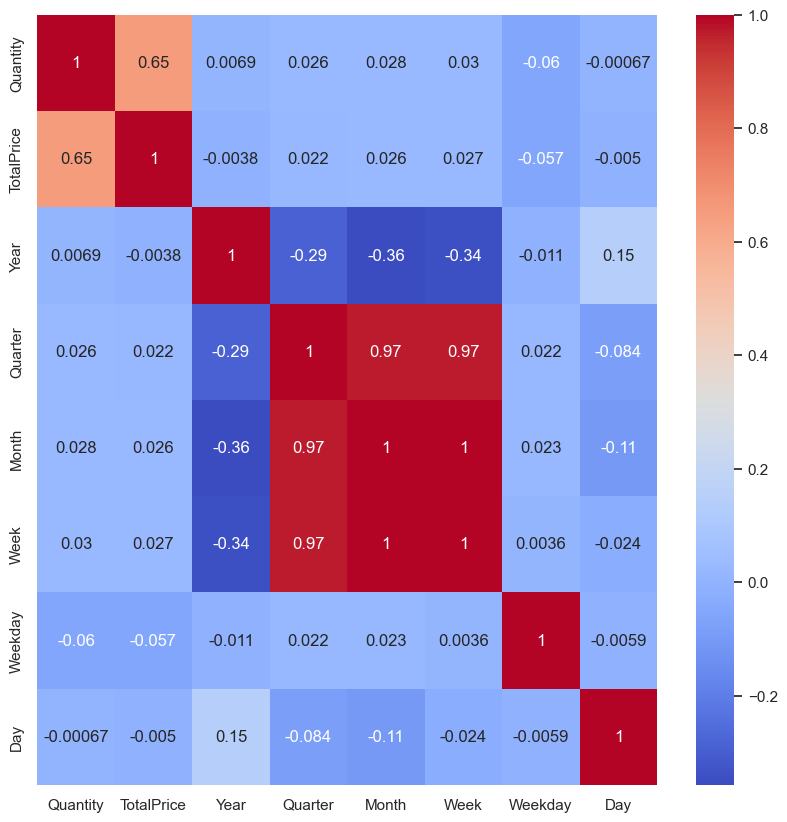

In [17]:
# Select only numeric columns
numeric_orders = orders.select_dtypes(include=['number'])

# Get correlations of numeric features
corrmat = numeric_orders.corr()

# Visualize the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

top_corr_features = corrmat.index
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat, annot=True, cmap="coolwarm")
plt.show()


Above heatmap shows strong correlation between Quarter, Month, Dayofyear and Week. We will drop , Dayofyear, quarter and month, and just keep week, as week is most strongly correlated with week. Year has strong correlation with Day, and as it is not strongly correlated with Quantity, we will drop it.

In [21]:
# List of columns to drop
columns_to_drop = ['Month', 'Quarter', 'Dayofyear', 'Year']

# Drop only columns that exist
orders.drop(columns=[col for col in columns_to_drop if col in orders.columns], inplace=True)



In [22]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Week,Weekday,Day
0,2010-12-01,10002,60,51.00,48,2,1
1,2010-12-01,10125,2,1.70,48,2,1
2,2010-12-01,10133,5,4.25,48,2,1
3,2010-12-01,15044B,1,2.95,48,2,1
4,2010-12-01,15056BL,20,113.00,48,2,1


In [23]:
orders.to_csv('data.csv')